# MCMC example script

In the previous tutorial scripts we explored a few statistics and how they varied when parameters were individually varied. However, what we often want to do instead is explore the full parameters space, in this example a 4D space. Due to the high dimensionality of the input parameters this typically can't be done 'by hand'. A common approach to fit a given statistics when all parameters are allowed to vary is to perform an Markov-Monte Carlo (MCMC) sampling. In this notebook we will use the python package `emcee` to fit the host stellar mass to that inferred from abundance matching.

Let's start by importing the functions we need.

In [1]:
import sys
sys.path.append('/cosma/home/dp004/dc-brow5/Python_Code/ARTEMIS_emulator/src') #update this path to wherever you downloaded the source code

import numpy as np
import matplotlib.pyplot as plt
import emcee
from Emulator_functions import emulator        #main class used to make predcition from the emulator
from Emulator_functions import rescale         #nice helper frunction
from Corner_plot import corner_plot            #class for making various corner plots
em = emulator()   

# Stellar mass halo mass relation

To start we need to specify the stellar mass halo mass relation we are going to fit to. Here we will use the relation from [Behroozi 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.3143B/abstract).

Text(0, 0.5, '$\\log M_{stel}/M_{200c}$')

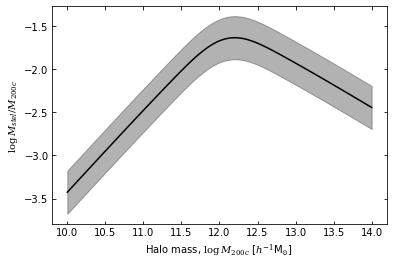

In [2]:
def SMHM(M):
    #Behroozi stellar mass function
    M_1 = 10**12.081
    eps = -1.435
    alpha = 1.957
    beta = 0.474
    sigma = 0.386
    gamma = 10**(-1.065)

    x = np.log10(M/M_1)
    M_st = eps
    M_st += -np.log10(10**(-alpha*x)+10**(-beta*x))
    M_st += gamma*np.exp(-0.5*(x/sigma)**2)
    M_st = 10**(M_st)*M_1


    std=np.ones(len(M))*0.25
    #std in dex
    return(M_st,std)

M_DM = np.logspace(10,14,100)
M_st, std = SMHM(M_DM)

plt.figure()
plt.plot(np.log10(M_DM),np.log10(M_st/M_DM),'k-')
plt.fill_between(np.log10(M_DM),np.log10(M_st/M_DM)-std,np.log10(M_st/M_DM)+std,alpha=0.3,color='black')

plt.xlabel('Halo mass, $\\log M_{200c}$ [$h^{-1}$M$_{\\odot}$]')
plt.ylabel('$\\log M_{stel}/M_{200c}$')

We now have the observation we want to match. i.e. we want to constrain the stellar mass such that we recover this relation (at least over the halo masses we sample). We therefore need to be able to predict the stellar mass from the emulator. You look at the `Emulator_first_use.ipynb` notebook for more details. Here we will use the stellar mass within 30kpc, and let's start with the prediction at the fiducial combination of parameters.

In [3]:
fiducial=np.array([np.infty,0.1,np.log10(3),np.log10(0.1),np.log10(50),11.5]).reshape(1,-1)
fiducial_norm=rescale(fiducial,normalised=False)

stel_mas , z = em.predict('ApertureMeasurements_Mass_030kpc_PartType4',fiducial,0.0,normalised=False)
#convert from log(M_st/(h^-1 M_sun) to M_sun
stel_mas = 10**(stel_mas+10)

print(stel_mas)

Sampling redshift 0.00
[1.92575058e+10 1.90696921e+10 3.21029857e+10]


Here we see that we get a prediction for the stellar mass for each halo. To then compare to the SMHM relation above we need to know the halo mass. While in general the halo mass is also (mildly) dependent on the choice of feedback, here we are going to use the halo mass in a dark matter only simulation, which is constant. While this has the advantage of simplifying the analysis by letting only the stellar mass be dependent on the feedback parameters, rather than both the stellar mass and halo mass, it is also more accurately mimics the results from the SMHM relation from Behroozi 2019, as here they match a given galaxie's stellar mass to the halo mass in a collisionless (DM only) simulation.

For convenience we have already calculated the DM only halo masses in the `./data/M_200c_DM_only.txt` file. Let's see how the fiducial combination of parameters compares with some different choices.

Statistic already loaded
Sampling redshift 0.00


Text(0, 0.5, '$\\log M_{stel}/M_{200c}$')

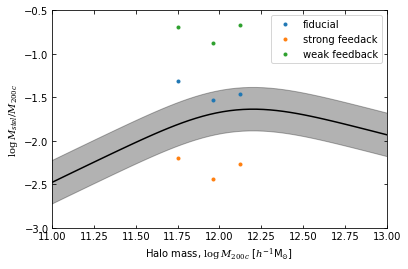

In [4]:
#load halo mass for DM only
M_200 = np.loadtxt('./data/M_200c_DM_only.txt') #array saved in opposite order

#set up paramter choices varying fmax
params = np.repeat(fiducial,3,axis=0)
params[1,2] = np.log10(10)
params[2,2] = np.log10(0.5)

stel_mas_fid , z = em.predict('ApertureMeasurements_Mass_030kpc_PartType4',params,0.0,normalised=False)
stel_mas_fid = 10**(stel_mas_fid+10)/0.7

#SMHM relation
M_DM = np.logspace(10,14,100)
M_st, std = SMHM(M_DM)

plt.figure()
plt.plot(np.log10(M_DM),np.log10(M_st/M_DM),'k-')
plt.fill_between(np.log10(M_DM),np.log10(M_st/M_DM)-std,np.log10(M_st/M_DM)+std,alpha=0.3,color='black')

labels = ['fiducial', 'strong feedack', 'weak feedback']
for i in range(len(stel_mas_fid)):
    plt.plot(np.log10(M_200),np.log10(stel_mas_fid[i,:]/M_200),'.',label=labels[i])


plt.ylim(-3,-0.5)
plt.xlim(11,13)
plt.legend()
plt.xlabel('Halo mass, $\\log M_{200c}$ [$h^{-1}$M$_{\\odot}$]')
plt.ylabel('$\\log M_{stel}/M_{200c}$')

Here we can see that the fiducial combination of parameters offers a reasonable fit to the SMHM relation, and is within the scatter. In fact the 'tru' fit is even better than this as the SMHM from Behroozi 19 uses a different mass definition than $M_{200c}$. Additionally, the fit is not a fluke, this is specifically how the fiducial combination of parameters was chosen, the simulations were calibrated to reproduce this SMHM relation. We have also plotted here a weaker and stronger feedback model that we see over, and under, shoots the SMHM relation.

In broad terms it is then clear from this analysis that the fiducial choice of parameters offers a decent fit to the Behroozi relation, while the weak feedback and string feedback clearly offer poor fits.

While it is a useful analysis to mess around with these parameters by hand and compare the emulator's prediction to the Behroozi relation (you should try this if you haven't already) there are a number of questions that are essentially impossible to answer with this approach of comparing the emulator’s predictions to the observations. In particular, we can think about:

- Do the fiducial combination of parameters a unique fit to the SMHM relation?
- What range of parameters offer a good fit? Instead of just giving a best fit value can we also provide errors/uncertainties to them?

Both of these can be answered using an MCMC analysis. Which is a powerful statistical tool for constraining model parameters based on given observations.

## MCMC analyses

Here we want to perform a MCMC analysis to ask what choice of feedback parameters, and star formation threshold provide a good fit to the Behroozi SMHM shown above. In what follows we will fix the WDM mass and reionisation to their fiducial values (though neither have a noticeable effect on the stellar mass). Before proceeding we first need to figure out how to quantitatively phrase the question in a Baysian way. As a quick primer on Baysian statistics we can write the posterior probability function on the model parameters as

$p(\vec{\theta}|M_{200c},M_{*}) \propto p(\vec{\theta}) \times p(M_{*} | M_{200c}, \vec{\theta})$

Here $\vec{\theta}$ is the fitted parameters, i.e. the model parameters that we allow to vary. Here this will be $\vec{\theta} = (A,f_{max},\rho_{H,0}, n^*_{H,0})$ (a 4D parameter space). $p(\vec{\theta}|M_{200c},M_{stel})$ is the posterior (or 'constraint') given the observed data. Here the observations are going to be the SMHM relation of Behroozi 2019. The goal of the MCMC analysis is to give us the left hand side of this equation, while we need to specify the two right hand terms.

$p(\vec{\theta})$ is what is known as the prior on the model parameters. This encodes any previous information about these parameters, such as previous experiments, physically allowed ranges, or modelling constraints. Here we will use a flat (uninformative) prior that constrains these parameters to the emulation range, as we do not trust the predictions beyond this. The prior (up to a constant) is then

$p(\theta_i) = \begin{cases}  1, & \text{if} & 0 < \theta_i < 1 \\
                             	0, & \text{otherwise.}
               	\end{cases}$
              	 
Where here we have assumed $\theta_i$ is in normalsied 'emulator' coordinates (i.e. between 0 and 1 is within the emulators trained range).

$p(M_{stel} | \vec{\theta})$ is the likelihood. Which describes the probability of the given prediction matching the observation. Here we want to take a prediction from the emulator, which has a given error, and match it to the mean SMHM relation of Behroozi 2019, within the measured scatter. We can write, up to a constant, the (log) likelihood for this as

### $\log p(M_{*} | \vec{\theta}) = \sum\limits_{n} \frac{(\log M_{*,obs,n} - \log M_{*,pred,n}(\vec{\theta}))^2}{\sigma_n^2(\theta)} +\log \sigma_n^2(\vec{\theta})$


Here the sum is over all three haloes. $M_{*,obs}$ is the observed stellar mass (i.e. the Behroozi relation) and $M_{*,pred,n}$ the prediction from the emulator. The 'error', $\sigma_n^2(\vec{\theta})$ is a combination of the intrinsic scatter to the SMHM relation from Behroozi (which we can treat as a constant), and the uncertainty in making the prediction from the emulator,

$\sigma_n^2(\vec{\theta}) = \sigma_{scat}^2 + \sigma_{em,n}^2(\vec{\theta})$.

We have additionally assumed that the likelihood is a log Guassian, a good approximation of both the scatter in the SMHM relation as well as the uncertainties on the emulator.

Let's now write the prior and posterior (and their )combination that we want as functions that we can then pass to emcee to perform the MCMC analysis. Note that emcee requires we provide the log likelihoods, i.e. $\log p$.

In [5]:
#here we will be performing a 4D analysis

#define falt prior over emualtion range
def log_prior(theta):
    a,b,c,d = theta
    if 0.0 < a < 1.0 and 0.0 < b < 1.0 and 0.0 < c < 1.0 and 0.0 < d < 1.0:
        return 0.0
    return -np.inf

#define likelihood, described above
def log_likelihood(theta):
    
    #need to add extra fixed apramters for the emulator
    theta_em = fiducial_norm.copy()
    theta_em[0,1:5] = theta
    
    #make prediction from the emulator
    stellar_mass,red,error = em.predict('ApertureMeasurements_Mass_030kpc_PartType4',theta_em,0.0,return_std=True,verbose=False)
    
    stellar_mass+=10-np.log10(0.7) #log M_*/M_sun
    
    M_st_beh,sigma = SMHM(M_200)
    M_st_beh=np.log10(M_st_beh)

    #add errors in quadrature
    error = (error**2 + sigma**2)**0.5

    L=np.sum(-0.5 * (M_st_beh - stellar_mass) ** 2 / error**2 + np.log(error**2))

    return (L)

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta)

Great, we're now just about ready to perform our MCMC analysis. We have specified the prior and likelihood we want and written it in such a form that we can pass it to emcee. The final things we now need to set up are specific to performing an MCMC analysis. These are:

- The starting 'guesses'. Where in the parameter space we start our walkers.
- How many walkers and steps to use to sample our parameter space.

For the guess it's usually good to start somewhere that offers a decent fit to the data. Here we already know that the fiducial choice is an ok fit, so let's start our walkers there, with a little scatter. We will also use 32 walkers with 10,000 steps each (it's kind of trial and error to figure the right number to use).

This code will take a few minutes to run.

In [6]:
from multiprocessing import Pool

nwalkers=32
nstep=int(10**4)
ndim=4 

pos = fiducial_norm[:,1:5] + 10**(-3.0) * np.random.randn(nwalkers, ndim) #start walkers close to fiducial combination of paramters

with Pool(processes=4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool,args=())
    sampler.run_mcmc(pos, nstep, progress=True)

#paramters about how many 'steps' in the MCMC cahins we should throw away
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:28<00:00, 113.12it/s]


That's it, we have now performed the MCMC analysis. We therefore now have all the information to explore what the posterior on the varied parameters is. What is actually returned by an MCMC analysis is a long list of points in the parameter space (here a 4D space) that are statistically drawn from the posterior probability density distribution. We can get these samples as follows

In [7]:
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
print(samples.shape)

(6208, 4)


Here we see that we have a bunch of points in the 4D space that we're sampling. The exact number is roughly half the number of steps we used, due to the amount of burn in and thinning that was required. Exactly what these are, and why we need to do them is somewhat technical to the particular type of MCMC analysis we performed, but is essentially needed to get a reliable sampling of the posterior.

The next step is to now try to visualise the posterior. We will use a common plotting technique known as a corner plot. Here each 2D projection of the underlying 4D space is plotted, where the probability density is calculated by binning/smoothing the individual points. It is also common to plot the 1-sigma (and 2-sigma) contours of the probability density, rather than the 2D scalar field itself.

We can use the `corner_plotter` package that is provided with the emulator code to do this.

/cosma/home/dp004/dc-brow5/Python_Code/ARTEMIS_emulator/src/Corner_plot.py:265: RuntimeWarning: invalid value encountered in divide
  inter_dist[:,1] = dist[cut,1]/dist[cut,0]


()

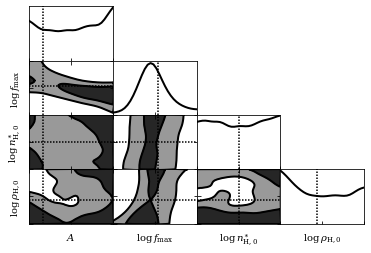

In [8]:
from Corner_plot import corner_plot

#set up labels and plotting limits
labels = em.get_parameter_labels()[1:5]
limits=[]
for i in range(ndim):
    limits.append([0,1])
    
cp = corner_plot(ndim,labels=labels)
cp.contour(samples, limits=limits,edge_correction=True,norm_1d=True,lw=2)

#plot fiducial values
cp.truths(fiducial_norm[0,1:5],color='black', linestyle='--', dashes=(1, 1))

Here we have plotted the constraint on all 4 parameters, presented as a corner plot. For those used to seeing these kinds of plots from other statistical analysis this may look like a mess, as none of the parameters show nice clear ellipsoids or banana shapes. This is primarily due to there being strong degeneracies in the parameters here. Let's go through some of the key features:

- Only $f_{max}$ is directly constrained (see the diagonal)
- There are strong degeneracies in the covariances. In particular the $f_{max}$-$A$ and the $rho_{H,0}$-$f_{max}$ projections.
- Many of the parameters show a preference for the edges of the parameter space. This is caused by the uncertainties on the emulator being larger here, as opposed to there being a better fit to the data.

You can read the paper for a more detailed discussion of this plot. But for this notebook the key point is that we have managed to constrain the parameters to reproduce a given SMHM relation, and can visualise what the posterior of that 4D space looks like.

Let's also double check that this combination of parameters does indeed give a good fit to the SMHM relation of Behroozi 19. Let's calculate the stellar mass for each of these, then plot the stellar masses with the std as 'error bars'.

Statistic already loaded
Sampling redshift 0.00


Text(0, 0.5, '$\\log M_{stel}/M_{200c}$')

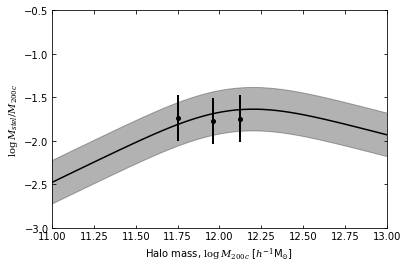

In [9]:
params = np.repeat(fiducial_norm,len(samples),axis=0)
params[:,1:5] = samples
stellar_mass,red = em.predict('ApertureMeasurements_Mass_030kpc_PartType4',params,0.0)
stellar_mass = 10**(stellar_mass+10.0-np.log10(0.7))

M_DM = np.logspace(10,14,100)
M_st, std = SMHM(M_DM)

plt.figure()
plt.plot(np.log10(M_DM),np.log10(M_st/M_DM),'k-')
plt.fill_between(np.log10(M_DM),np.log10(M_st/M_DM)-std,np.log10(M_st/M_DM)+std,alpha=0.3,color='black')

#calculate perceintles to plot as median and std
percentiles = np.percentile(stellar_mass,[50-34.1,50,50+34.1],axis=0)
plt.errorbar(np.log10(M_200),np.log10(percentiles[:,1]/M_200),yerr=np.log10(percentiles[:,2])-np.log10(percentiles[:,0]),marker='.',ls='none',markersize=8,color='black',elinewidth=2)

plt.ylim(-3,-0.5)
plt.xlim(11,13)
plt.xlabel('Halo mass, $\\log M_{200c}$ [$h^{-1}$M$_{\\odot}$]')
plt.ylabel('$\\log M_{stel}/M_{200c}$')

Here we see that the agreement between the data (i.e. the SMHM relation) and the prediction for the emulator is good. We are able to reproduce that SMHM relation from the emulator. However, there is not one combination of parameters that does this. We also see that the scatter in the distribution is roughly the same size as the scatter assumed in the SMHM relation, suggesting that is the limiting uncertainty.